In [1]:
import json

import numpy as np
import torch

from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import GreaterThan
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import GammaPrior, NormalPrior
from gpytorch.likelihoods import GaussianLikelihood, FixedNoiseGaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

from utils.bo_utils import GPModel, plot_optimization, expected_improvement
from bayesian_optimization import BayesianOptimization

In [2]:
log_dir = "../bo_exps/bo"
results = torch.load(f"{log_dir}/results.pt")
params_space = results["p_space"].reshape(-1, 1)

In [3]:
config = "./configs/bo_prior_sigma"
with open(config + ".json") as f:
    config = json.load(f)
    
lengthscale_prior = config["lengthscale_prior"] if "lengthscale_prior" in list(config.keys()) else dict(concentration=0.3, rate=1.)
lengthscale_constraint = config["lengthscale_constraint"] if "lengthscale_constraint" in list(config.keys()) else 0.05
mean_prior = config["mean_prior"] if "mean_prior" in list(config.keys()) else dict(loc=25., scale=2.)
noise_prior = config["noise_prior"] if "noise_prior" in list(config.keys()) else dict(concentration=1e-2, rate=100.)

params = {p["name"]: p["bounds"] for p in config["parameter"]}
bounds = np.array(list(params.values()))

acq_kwargs = {"xi": 0.1}

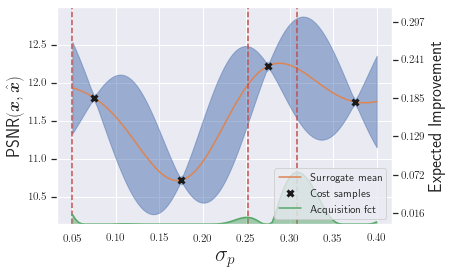

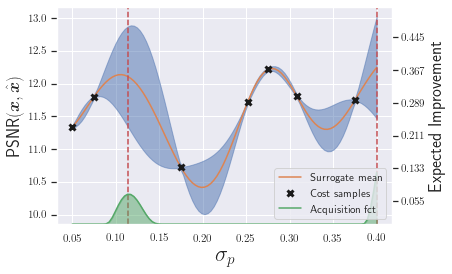

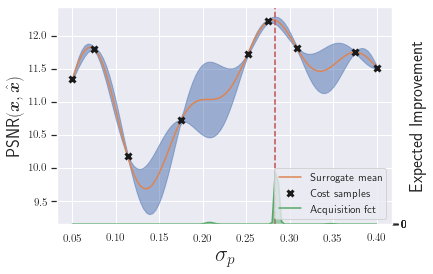

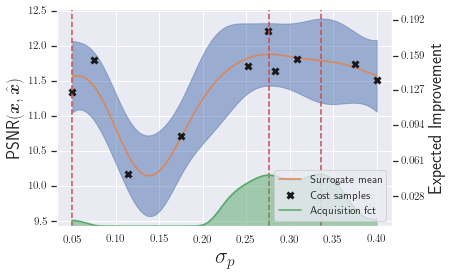

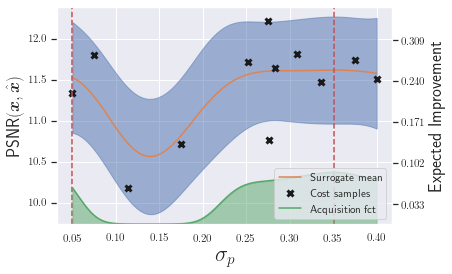

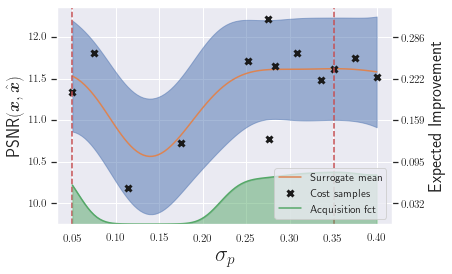

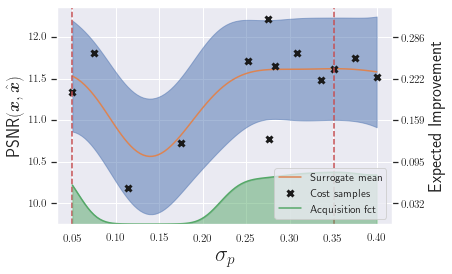

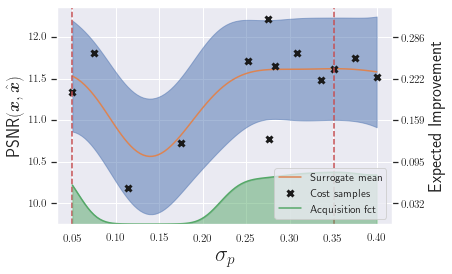

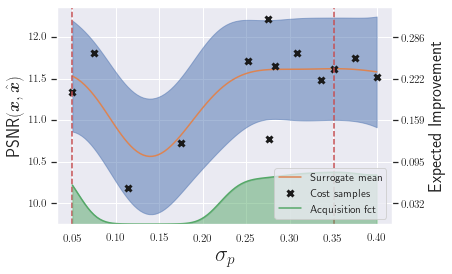

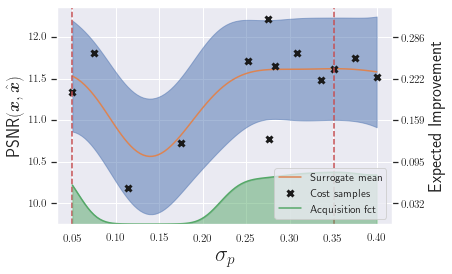

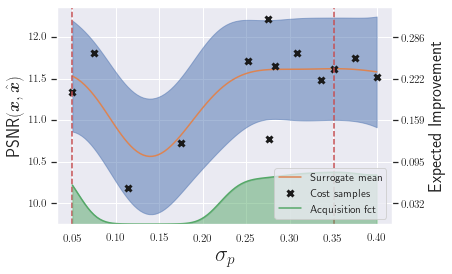

In [4]:
likelihood = GaussianLikelihood(noise_prior=GammaPrior(**noise_prior))

for i in range(len(results) - 1):
    vals = results[i]
    
    params_samples = vals["p_samples"]
    cost_samples = vals["c_samples"]
    
    eval_acq = lambda params, model, likelihood: expected_improvement(
        model, likelihood, params, 
        params_samples, cost_samples, **acq_kwargs
    )
    
    model = GPModel(
        params_samples, cost_samples, likelihood, lengthscale_prior,
        lengthscale_constraint, mean_prior
    ).double()
    
    model.load_state_dict(vals["state_dict"])

    next_params = BayesianOptimization.propose_location(
        model=model, likelihood=likelihood, eval_acq=eval_acq, 
        params_space=params_space, bounds=bounds, batch_size=3
    )
    
    acquisition = eval_acq(params_space.numpy(), model, likelihood)
    path = None # f"../bo_exps/fig_{i}.pdf"
    plot_optimization(
        model, likelihood, acquisition,
        next_params, params_space,
        params_samples, cost_samples, path
    )